# Importing modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('inpatientCharges.csv')

# EDA 

In [3]:
data.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,"$32,963.07","$5,777.24","$4,763.73"
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,"$15,131.85","$5,787.57","$4,976.71"
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,"$37,560.37","$5,434.95","$4,453.79"
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,"$13,998.28","$5,417.56","$4,129.16"
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,"$31,633.27","$5,658.33","$4,851.44"


In [4]:
# Get only 3 numbers from DRG Definition for plots later
data['DRG_ID'] = data['DRG Definition'].map(lambda x: x[0:3])

In [5]:
# Remove "$" and "," in three columns
data[' Average Covered Charges '] = data[' Average Covered Charges '].map(lambda x: x[1:].replace(",",""))
data[' Average Total Payments '] = data[' Average Total Payments '].map(lambda x: x[1:].replace(",",""))
data['Average Medicare Payments'] = data['Average Medicare Payments'].map(lambda x: x[1:].replace(",",""))

In [6]:
# Check the data typs of each column
data.dtypes

DRG Definition                          object
Provider Id                              int64
Provider Name                           object
Provider Street Address                 object
Provider City                           object
Provider State                          object
Provider Zip Code                        int64
Hospital Referral Region Description    object
 Total Discharges                        int64
 Average Covered Charges                object
 Average Total Payments                 object
Average Medicare Payments               object
DRG_ID                                  object
dtype: object

In [7]:
# Convert object to float for numeric columns
data[' Total Discharges '] = data[' Total Discharges '].astype(float)
data[' Average Covered Charges '] = data[' Average Covered Charges '].astype(float)
data[' Average Total Payments '] = data[' Average Total Payments '].astype(float)
data['Average Medicare Payments'] = data['Average Medicare Payments'].astype(float)

### Box plot for EDA

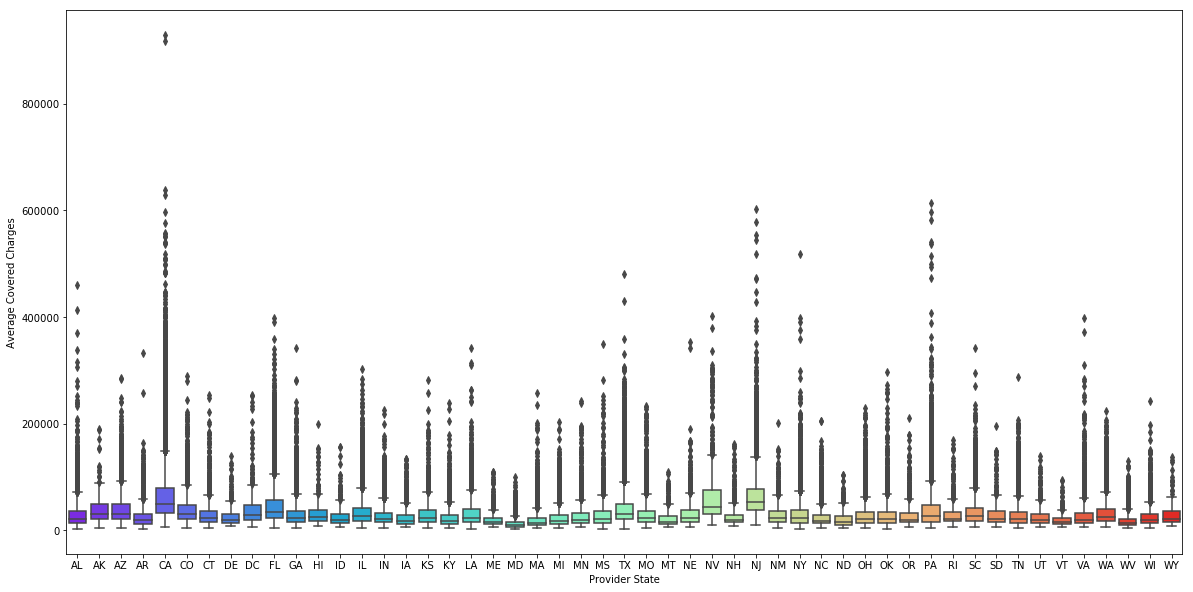

In [8]:
# Box ploy: State & Average Covered Changes
plt.figure(figsize=(20,10))
sns.boxplot(x='Provider State', y=' Average Covered Charges ', data=data, palette='rainbow')

#### Finding:  There is difference depending on state

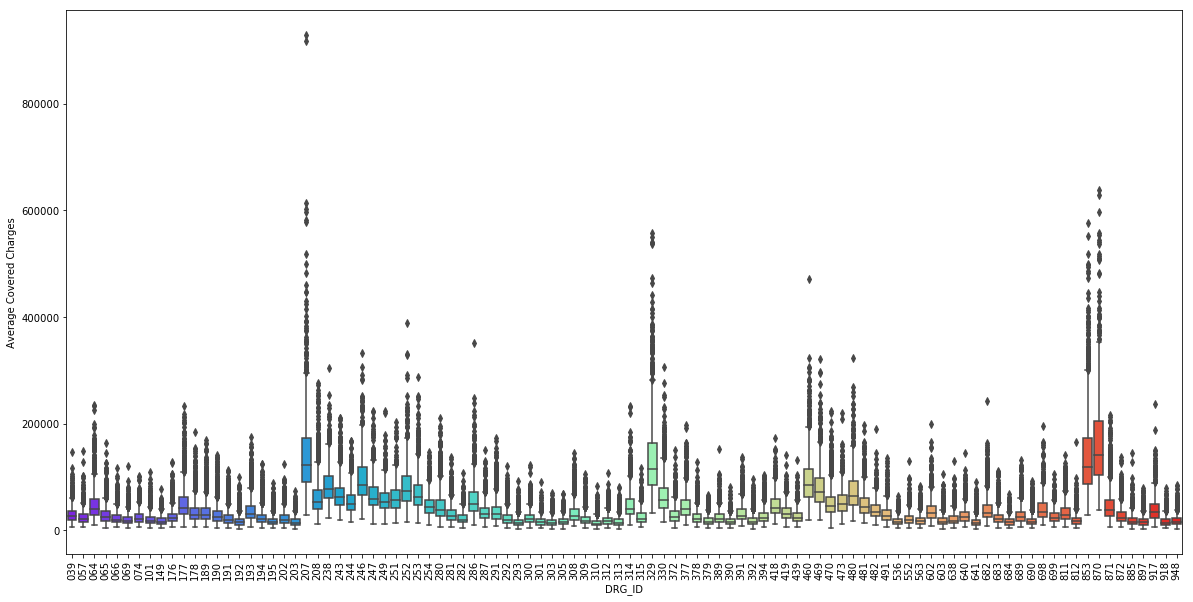

In [9]:
# Box ploy: DRG ID & Average Covered Changes
plt.figure(figsize=(20,10))
g = sns.boxplot(x='DRG_ID', y=' Average Covered Charges ', data=data, palette='rainbow')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()


#### Finding: There is also difference of distiribution depending on DRG ID 

### To compare characteristic by states, I chose two  states which show quite different distribution: CA & ND

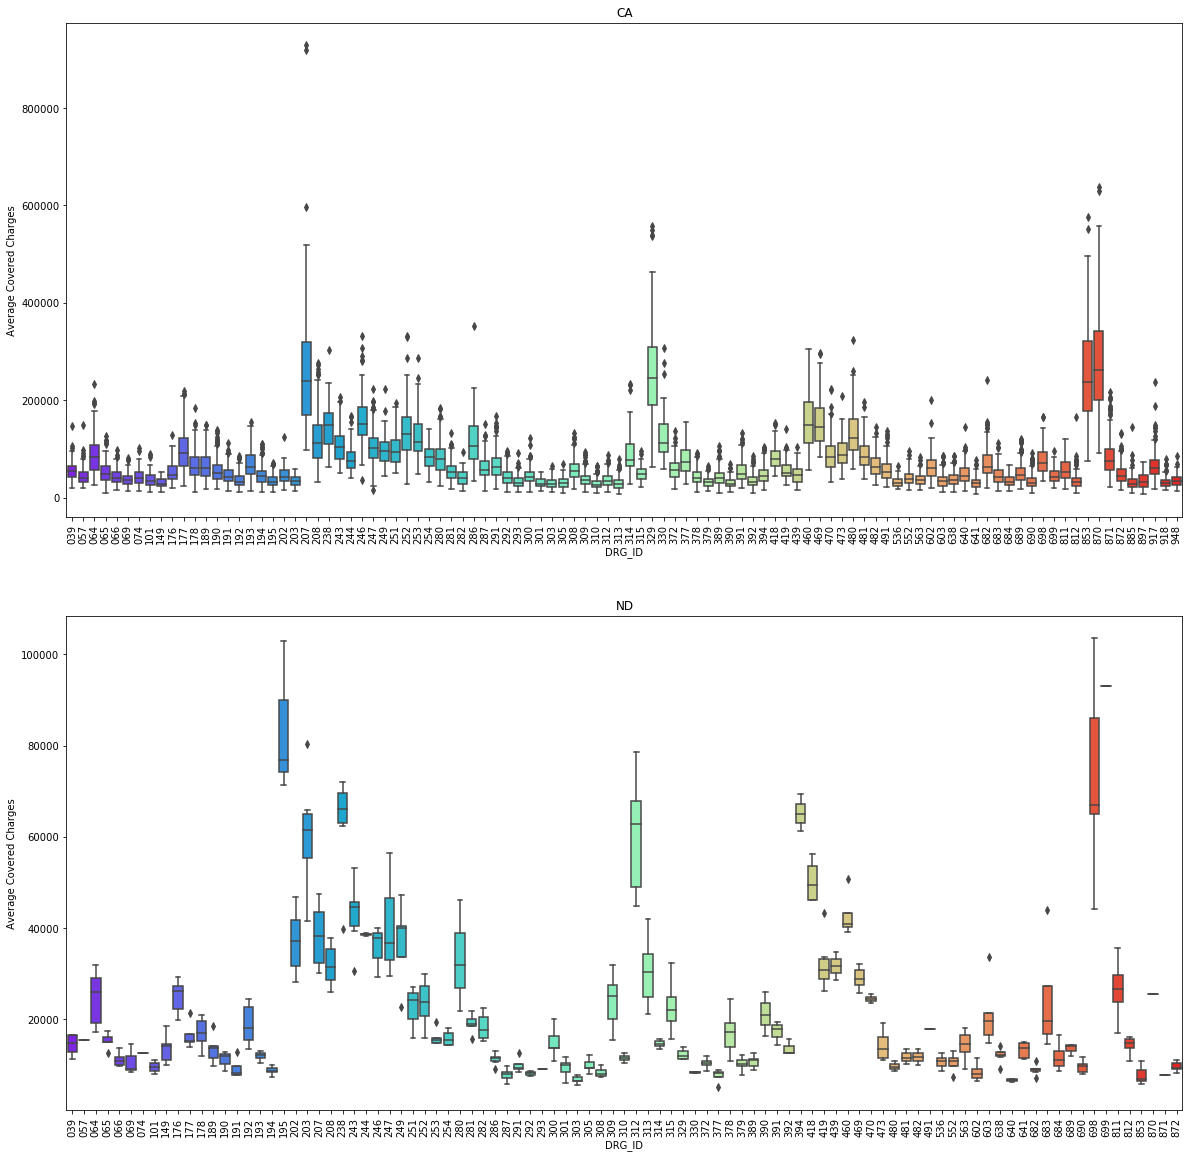

In [10]:
# Box plots for CA & ND
CA = data[data['Provider State'] == 'CA']
ND = data[data['Provider State'] == 'ND']

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,20))
g = sns.boxplot(x='DRG_ID', y=' Average Covered Charges ', data=CA, palette='rainbow', ax=axes[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('CA')

h = sns.boxplot(x='DRG_ID', y=' Average Covered Charges ', data=ND, palette='rainbow', ax=axes[1])
h.set_xticklabels(g.get_xticklabels(), rotation=90)
h.set_title('ND')
plt.show()

#### Finding: In the case of ND, it shows more uneven boxes compared to CA. So I checked more detailed things about ND

In [11]:
# Check the number of Provier by each DRG ID
data[data['Provider State']=='ND'].groupby(['DRG_ID'])['Provider Id'].unique().head(15)

DRG_ID
039    [350002, 350006, 350011, 350015, 350019, 350070]
057                                            [350011]
064    [350002, 350006, 350011, 350015, 350019, 350070]
065    [350002, 350006, 350011, 350015, 350019, 350070]
066    [350002, 350006, 350011, 350015, 350019, 350070]
069                            [350011, 350015, 350019]
074                                            [350011]
101                                    [350011, 350019]
176    [350002, 350006, 350011, 350015, 350019, 350070]
177    [350002, 350006, 350011, 350015, 350019, 350070]
178            [350002, 350006, 350011, 350015, 350019]
189    [350002, 350006, 350011, 350015, 350019, 350070]
190    [350002, 350006, 350011, 350015, 350019, 350070]
191    [350015, 350002, 350006, 350011, 350019, 350070]
192                    [350006, 350011, 350019, 350070]
Name: Provider Id, dtype: object

#### Finding: As you can see, there are only 1~3 providers in certain DRG ID in ND. I think that that's why ND shows uneven boxes. So, I will carefully deal with the combination with Provider Id and DRG ID having the small number.

# Feature Engineering

## Waste & Abuse Case 1: To define suspicious cases, I will check the abnormal (high) features by comparing each provider to other providers by each state because each state has a different price. To do this, I will use Robust Scaler becuase it is better to keep the characteristics of outliers.

### I'll remove several data which have only 1 ~ 3 data in the certain state & DRG because scaling is meaningless in this case.

In [12]:
# Robust scaling
id_list = data['DRG_ID'].unique()
st_list = data['Provider State'].unique()
new_df = pd.DataFrame()

for i in id_list:
    for j in st_list:
        temp_df = data[data['DRG_ID'] == i].reset_index(drop=True)
        temp_df = temp_df[temp_df['Provider State'] == j].reset_index(drop=True)
        robust_df = temp_df[[' Total Discharges ',' Average Covered Charges ',' Average Total Payments ','Average Medicare Payments']]
        robust_id = temp_df[['DRG_ID', 'Provider State']]
        provider_id = temp_df['Provider Id']
        if robust_df.shape[0] > 3 :
            scaler = RobustScaler().fit(robust_df)
            result = scaler.transform(robust_df)
            result = pd.DataFrame(result, columns=['robust_TDC','robust_ACC','robust_ATT','robust_AMP'])
            robust_df = pd.concat([provider_id, robust_id, result], axis=1, sort=False)
            new_df = pd.concat([new_df, robust_df], sort=False)

In [13]:
new_df.head()

,Provider Id,DRG_ID,Provider State,robust_TDC,robust_ACC,robust_ATT,robust_AMP
0,10001,039,AL,2.583333,0.192444,0.244510,0.479651
1,10005,039,AL,-0.625000,-0.580475,0.265751,0.829441
2,10006,039,AL,-0.208333,0.391720,-0.459327,-0.029382
3,10011,039,AL,-0.166667,-0.629611,-0.495086,-0.562541
4,10016,039,AL,-0.458333,0.134802,0.000000,0.623703


### Now I have the values of Robust Scaler by a state and a DRG ID. To summarize for each provider, I could simply calulate average(mean), but it would not be enough because there is a possibility to add unnecessary treatments or medicines into a certain DRG only. Therefore, I will also calculate average of top 3 & top 5 DRG ID.

In [14]:
# Calculate average for all, Top3, and Top5
provider_list = data['Provider Id'].unique()
WNA1 = pd.DataFrame(index=provider_list, columns = ['Mean_rbs_TDC','Top3_rbs_TDC','Top5_rbs_TDC','Mean_rbs_ACC','Top3_rbs_ACC','Top5_rbs_ACC','Mean_rbs_ATT','Top3_rbs_ATT','Top5_rbs_ATT','Mean_rbs_AMP','Top3_rbs_AMP','Top5_rbs_AMP'])

for i in provider_list:
    WNA1.loc[i, 'Mean_rbs_TDC'] = new_df[new_df['Provider Id'] == i]['robust_TDC'].mean()
    WNA1.loc[i, 'Top3_rbs_TDC'] = new_df[new_df['Provider Id'] == i]['robust_TDC'].sort_values(ascending=False).head(3).mean()
    WNA1.loc[i, 'Top5_rbs_TDC'] = new_df[new_df['Provider Id'] == i]['robust_TDC'].sort_values(ascending=False).head(5).mean()
    
    WNA1.loc[i, 'Mean_rbs_ACC'] = new_df[new_df['Provider Id'] == i]['robust_ACC'].mean()
    WNA1.loc[i, 'Top3_rbs_ACC'] = new_df[new_df['Provider Id'] == i]['robust_ACC'].sort_values(ascending=False).head(3).mean()
    WNA1.loc[i, 'Top5_rbs_ACC'] = new_df[new_df['Provider Id'] == i]['robust_ACC'].sort_values(ascending=False).head(5).mean()
    
    WNA1.loc[i, 'Mean_rbs_ATT'] = new_df[new_df['Provider Id'] == i]['robust_ATT'].mean()
    WNA1.loc[i, 'Top3_rbs_ATT'] = new_df[new_df['Provider Id'] == i]['robust_ATT'].sort_values(ascending=False).head(3).mean()
    WNA1.loc[i, 'Top5_rbs_ATT'] = new_df[new_df['Provider Id'] == i]['robust_ATT'].sort_values(ascending=False).head(5).mean()
    
    WNA1.loc[i, 'Mean_rbs_AMP'] = new_df[new_df['Provider Id'] == i]['robust_AMP'].mean()
    WNA1.loc[i, 'Top3_rbs_AMP'] = new_df[new_df['Provider Id'] == i]['robust_AMP'].sort_values(ascending=False).head(3).mean()
    WNA1.loc[i, 'Top5_rbs_AMP'] = new_df[new_df['Provider Id'] == i]['robust_AMP'].sort_values(ascending=False).head(5).mean()
    

In [15]:
# Final dataset of W&A 1
WNA1.head()

,Mean_rbs_TDC,Top3_rbs_TDC,Top5_rbs_TDC,Mean_rbs_ACC,Top3_rbs_ACC,Top5_rbs_ACC,Mean_rbs_ATT,Top3_rbs_ATT,Top5_rbs_ATT,Mean_rbs_AMP,Top3_rbs_AMP,Top5_rbs_AMP
10001,0.980914,3.8982,3.55608,0.179979,0.985912,0.889107,0.169669,1.46376,1.18114,0.15071,0.835874,0.786382
10005,-0.122003,0.902941,0.754543,-0.620222,-0.133232,-0.171574,0.344568,1.89212,1.45119,0.330296,1.1701,1.05305
10006,0.450994,2.5517,2.25896,0.210059,0.845503,0.781707,-0.257891,1.43004,1.18951,-0.315628,0.833012,0.609355
10011,0.0700672,1.37407,1.20222,-0.15858,0.635996,0.578962,0.111719,2.40581,2.01592,-0.164115,1.0506,0.826209
10016,0.0208533,0.964854,0.848152,0.663805,1.77307,1.61183,0.154058,2.16535,1.74424,-0.0133075,0.650612,0.625932


## Waste & Abuse Case 2: Suspicious providers could make fake records to get some profit from Medicare. To make more profits in this way, they might focus on certain diseases (DRG) that have a portion more covered by Medicare. Therefore, I calculated the portion of "Average Medicare Payments" out of "Average Covered Charges".
## For this reason, I will not deal with "Average Total Payment" at this chapter.

In [16]:
# Calculated the portion of "Average Medicare Payment" out of "Average Covered Charges": AMP_Covered_Portion
data['AMP_Covered_Portion'] = data['Average Medicare Payments'] / data[' Average Covered Charges ']

Text(0.5, 1.0, 'AMP')

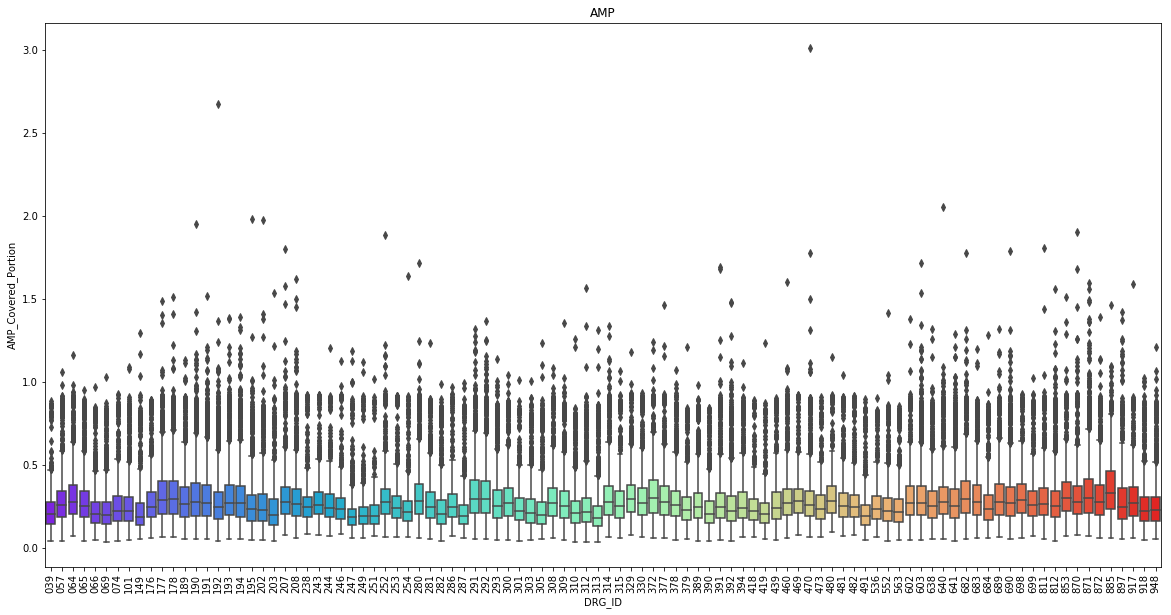

In [17]:
# Distribution of AMP_Covered_Portion by each DRG ID
plt.figure(figsize=(20,10))

h = sns.boxplot(x='DRG_ID', y='AMP_Covered_Portion', data=data, palette='rainbow')
h.set_xticklabels(g.get_xticklabels(), rotation=90)
h.set_title('AMP')

#### Finding: If this value is larger than 1.0, we could consider them as suspicious cases, but I will add more feature to make it clear. 

## Standardization with RobustScaler

### As we can see above, each DRG ID shows different distributions and outliers. To detect outliers more clearly, I conducted standardization, but instead of StandardScaler, I used RobustScaler because median is better way to deal with outliers. 

In [18]:
# Standardiation with three columns(' Average Covered Charges ','Average Medicare Payments', 'AMP_Covered_Portion') by DGR ID

id_list = data['DRG_ID'].unique()
new_df = pd.DataFrame()

for i in id_list:
    df_id = data[data['DRG_ID'] == i].reset_index(drop=True)
    df_id_col = df_id[[' Average Covered Charges ','Average Medicare Payments', 'AMP_Covered_Portion']]
    scaler = RobustScaler().fit(df_id_col)
    result = scaler.transform(df_id_col)      
    result = pd.DataFrame(result, columns=['RBS_ACC','RBS_AMP','RBS_AMP'])
    df_id = pd.concat([df_id, result], axis=1, sort=False)
    new_df = pd.concat([new_df, df_id], sort=False)

### Although the value of AMP_Covered_Portion is high in some cases, we are not sure that those cases are fraud cases. Therefore, another assumption is that they will try to manipulate with a lot of times or a lot of amounts, or both in the certain DGR ID.

In [19]:
# calculate sum of three columns by each provider
id_summary = new_df[['Provider Id',' Total Discharges ','Average Medicare Payments']].groupby(['Provider Id']).sum().reset_index()

# Change columns names to combine
id_summary = id_summary.rename(columns={' Total Discharges ':'Sum_Total_Discharges', 'Average Medicare Payments':'Sum_Average_Medicare_Payments'})                   

# combine two tables
new_df = pd.merge(new_df, id_summary, on='Provider Id', how='left')

In [20]:
# Calculate each DRG ID portions of Total Discharge and Average Medicare Payment by each provider

new_df['Portion_Total_Discharges'] = new_df[' Total Discharges ']/new_df['Sum_Total_Discharges']
new_df['Portion_Average_Medicare_Payments'] = new_df['Average Medicare Payments']/new_df['Sum_Average_Medicare_Payments']

### Next, I made new features by using the above features. To make it clear, let me explain the features again.

#### AMP_Converted_Portion: The ratio covered by Medicare
#### Portion_Total_Discharges: The ratio of each DRG ID out of the sum of Total Discharge (by each provider)
#### Portion_Average_Medicare_Payments: The ratio of each DRG ID out of the sum of Average Medicare Payments (by each provider)
#### If fraudsters focus on DRG ID having a high value of AMP_Convereted_Portion on purpose, Portion_Total_Discharges and Portion_Average_Medicare_Payments also show high values. So, I multiplied them to each other.

In [21]:
# Multiply each feature
new_df['AMP_Covered_Portion X TOTAL'] = new_df['AMP_Covered_Portion'] * new_df['Portion_Total_Discharges']
new_df['AMP_Covered_Portion X AMP'] = new_df['AMP_Covered_Portion'] * new_df['Portion_Average_Medicare_Payments']
new_df['AMP_Covered_Portion X TOTAL X AMP'] = new_df['AMP_Covered_Portion'] * new_df['Portion_Total_Discharges'] * new_df['Portion_Average_Medicare_Payments']

### To summarize this information by each provider, I got the value of maximum, minimum, mean, and range(max-min), but among them, I guess that maximum would be the most important feature.

In [22]:
# Get summary (Min, Max, Mean)
provider_summary = new_df.groupby('Provider Id').aggregate({'AMP_Covered_Portion':['min','max','mean'],
                                                            'AMP_Covered_Portion X TOTAL':['min','max','mean'],
                                                            'AMP_Covered_Portion X AMP':['min','max','mean'],
                                                            'AMP_Covered_Portion X TOTAL X AMP':['min','max','mean']})

In [23]:
# Convert heirarchical index
provider_summary.columns = [' '.join(col).strip() for col in provider_summary.columns.values]

In [24]:
# Calculate Range
provider_summary['AMP_Covered_Portion range'] = provider_summary['AMP_Covered_Portion max'] = provider_summary['AMP_Covered_Portion min']
provider_summary['AMP_Covered_Portion X TOTAL range'] = provider_summary['AMP_Covered_Portion X TOTAL max'] = provider_summary['AMP_Covered_Portion X TOTAL min']
provider_summary['AMP_Covered_Portion X AMP range'] = provider_summary['AMP_Covered_Portion X AMP max'] = provider_summary['AMP_Covered_Portion X AMP min']
provider_summary['AMP_Covered_Portion X TOTAL X AMP range'] = provider_summary['AMP_Covered_Portion X TOTAL X AMP max'] = provider_summary['AMP_Covered_Portion X TOTAL X AMP min']

In [25]:
provider_summary = provider_summary.reset_index()

### I will calculate Top 3 & Top 5 highest values of each feature by using mean again.

In [26]:
# Get Top 3 & Top 5

provider = pd.DataFrame()
provider_list = new_df['Provider Id'].unique()

for i in provider_list:
    provider.loc[i,'Top_3_AMP_Covered_Portion'] = new_df[new_df['Provider Id']==i].sort_values(by='AMP_Covered_Portion', ascending=False).head(3)['AMP_Covered_Portion'].mean()
    provider.loc[i,'Top_3_AMP_Covered_Portion X TOTAL'] = new_df[new_df['Provider Id']==i].sort_values(by='AMP_Covered_Portion X TOTAL', ascending=False).head(3)['AMP_Covered_Portion X TOTAL'].mean()
    provider.loc[i,'Top_3_AMP_Covered_Portion X AMP'] = new_df[new_df['Provider Id']==i].sort_values(by='AMP_Covered_Portion X AMP', ascending=False).head(3)['AMP_Covered_Portion X AMP'].mean()
    provider.loc[i,'Top_3_AMP_Covered_Portion X TOTAL X AMP'] = new_df[new_df['Provider Id']==i].sort_values(by='AMP_Covered_Portion X TOTAL X AMP', ascending=False).head(3)['AMP_Covered_Portion X TOTAL X AMP'].mean()
    
    provider.loc[i,'Top_5_AMP_Covered_Portion'] = new_df[new_df['Provider Id']==i].sort_values(by='AMP_Covered_Portion', ascending=False).head(5)['AMP_Covered_Portion'].mean()
    provider.loc[i,'Top_5_AMP_Covered_Portion X TOTAL'] = new_df[new_df['Provider Id']==i].sort_values(by='AMP_Covered_Portion X TOTAL', ascending=False).head(5)['AMP_Covered_Portion X TOTAL'].mean()
    provider.loc[i,'Top_5_AMP_Covered_Portion X AMP'] = new_df[new_df['Provider Id']==i].sort_values(by='AMP_Covered_Portion X AMP', ascending=False).head(5)['AMP_Covered_Portion X AMP'].mean()
    provider.loc[i,'Top_5_AMP_Covered_Portion X TOTAL X AMP'] = new_df[new_df['Provider Id']==i].sort_values(by='AMP_Covered_Portion X TOTAL X AMP', ascending=False).head(5)['AMP_Covered_Portion X TOTAL X AMP'].mean()    
    

In [27]:
# Convert index to combine tables
provider = provider.reset_index()
provider = provider.rename(columns={'index':'Provider Id'})

In [28]:
# Combine tables for the final table
WNA2 = pd.merge(provider, provider_summary, on='Provider Id', how='inner')

# Make index with Provider ID for clustering
WNA2.set_index('Provider Id',inplace=True)

### Combine results of Waste & Abuse 1 and  Waste & Abuse 2

In [29]:
WNA1.reset_index(inplace=True)
WNA1 = WNA1.rename(columns={'index': 'Provider Id'})
WNA2.reset_index(inplace=True)

In [30]:
final_df = pd.merge(WNA1, WNA2, on='Provider Id', how='left')

In [31]:
final_df.head()

,Provider Id,Mean_rbs_TDC,Top3_rbs_TDC,Top5_rbs_TDC,Mean_rbs_ACC,Top3_rbs_ACC,Top5_rbs_ACC,Mean_rbs_ATT,Top3_rbs_ATT,Top5_rbs_ATT,Mean_rbs_AMP,Top3_rbs_AMP,Top5_rbs_AMP,Top_3_AMP_Covered_Portion,Top_3_AMP_Covered_Portion X TOTAL,Top_3_AMP_Covered_Portion X AMP,Top_3_AMP_Covered_Portion X TOTAL X AMP,Top_5_AMP_Covered_Portion,Top_5_AMP_Covered_Portion X TOTAL,Top_5_AMP_Covered_Portion X AMP,Top_5_AMP_Covered_Portion X TOTAL X AMP,AMP_Covered_Portion min,AMP_Covered_Portion max,AMP_Covered_Portion mean,AMP_Covered_Portion X TOTAL min,AMP_Covered_Portion X TOTAL max,AMP_Covered_Portion X TOTAL mean,AMP_Covered_Portion X AMP min,AMP_Covered_Portion X AMP max,AMP_Covered_Portion X AMP mean,AMP_Covered_Portion X TOTAL X AMP min,AMP_Covered_Portion X TOTAL X AMP max,AMP_Covered_Portion X TOTAL X AMP mean,AMP_Covered_Portion range,AMP_Covered_Portion X TOTAL range,AMP_Covered_Portion X AMP range,AMP_Covered_Portion X TOTAL X AMP range
0,10001,0.980914,3.8982,3.55608,0.179979,0.985912,0.889107,0.169669,1.46376,1.18114,0.15071,0.835874,0.786382,0.329979,0.010631,0.011733,0.000126,0.311042,0.009191,0.010577,0.000107,0.107130,0.107130,0.207866,0.000256,0.000256,0.002287,0.000317,0.000317,0.002474,8.614688e-07,8.614688e-07,0.000024,0.107130,0.000256,0.000317,8.614688e-07
1,10005,-0.122003,0.902941,0.754543,-0.620222,-0.133232,-0.171574,0.344568,1.89212,1.45119,0.330296,1.1701,1.05305,0.550619,0.018391,0.016270,0.000487,0.532473,0.017268,0.015842,0.000441,0.208484,0.208484,0.367445,0.001616,0.001616,0.007459,0.002558,0.002558,0.007599,2.037907e-05,2.037907e-05,0.000155,0.208484,0.001616,0.002558,2.037907e-05
2,10006,0.450994,2.5517,2.25896,0.210059,0.845503,0.781707,-0.257891,1.43004,1.18951,-0.315628,0.833012,0.609355,0.314409,0.010894,0.009960,0.000131,0.292413,0.009649,0.008871,0.000111,0.084208,0.084208,0.191842,0.000281,0.000281,0.002299,0.000234,0.000234,0.002324,7.783371e-07,7.783371e-07,0.000024,0.084208,0.000281,0.000234,7.783371e-07
3,10011,0.0700672,1.37407,1.20222,-0.15858,0.635996,0.578962,0.111719,2.40581,2.01592,-0.164115,1.0506,0.826209,0.457519,0.013894,0.013061,0.000212,0.441045,0.010937,0.011229,0.000158,0.138271,0.138271,0.246728,0.000664,0.000664,0.002783,0.000567,0.000567,0.003044,2.587777e-06,2.587777e-06,0.000032,0.138271,0.000664,0.000567,2.587777e-06
4,10016,0.0208533,0.964854,0.848152,0.663805,1.77307,1.61183,0.154058,2.16535,1.74424,-0.0133075,0.650612,0.625932,0.279031,0.006680,0.009567,0.000135,0.253626,0.005915,0.007945,0.000106,0.098994,0.098994,0.161176,0.000523,0.000523,0.001951,0.000399,0.000399,0.002165,2.228776e-06,2.228776e-06,0.000025,0.098994,0.000523,0.000399,2.228776e-06


## Standardization with StandardScaler for final dataset:  
#### Although I conducted robust scaling for both W&B1 and W&B2, the scales of two result are quite different because I calulated more in W&B2. To make them have same scale, I will use Standard Sclaer here. I used Robust Scaler for this data, but the result keeped a huge difference between W&B1 and W&B2. That's why I use Standard Scaler here.

In [32]:
# Standard Scaling
rbs_df = final_df.set_index('Provider Id')
for i in rbs_df.columns:
    rbs_df[i] = rbs_df[i].astype('float64')

In [33]:
# Standard Scaling
rbs_df = final_df.set_index('Provider Id')
final_scaler = StandardScaler().fit(rbs_df)
final_scaler_result = final_scaler.transform(rbs_df)
final_df_rbs = pd.DataFrame(final_scaler_result, columns=rbs_df.columns, index=rbs_df.index)

In [34]:
# Check dataset
final_df_rbs.head()

,Mean_rbs_TDC,Top3_rbs_TDC,Top5_rbs_TDC,Mean_rbs_ACC,Top3_rbs_ACC,Top5_rbs_ACC,Mean_rbs_ATT,Top3_rbs_ATT,Top5_rbs_ATT,Mean_rbs_AMP,Top3_rbs_AMP,Top5_rbs_AMP,Top_3_AMP_Covered_Portion,Top_3_AMP_Covered_Portion X TOTAL,Top_3_AMP_Covered_Portion X AMP,Top_3_AMP_Covered_Portion X TOTAL X AMP,Top_5_AMP_Covered_Portion,Top_5_AMP_Covered_Portion X TOTAL,Top_5_AMP_Covered_Portion X AMP,Top_5_AMP_Covered_Portion X TOTAL X AMP,AMP_Covered_Portion min,AMP_Covered_Portion max,AMP_Covered_Portion mean,AMP_Covered_Portion X TOTAL min,AMP_Covered_Portion X TOTAL max,AMP_Covered_Portion X TOTAL mean,AMP_Covered_Portion X AMP min,AMP_Covered_Portion X AMP max,AMP_Covered_Portion X AMP mean,AMP_Covered_Portion X TOTAL X AMP min,AMP_Covered_Portion X TOTAL X AMP max,AMP_Covered_Portion X TOTAL X AMP mean,AMP_Covered_Portion range,AMP_Covered_Portion X TOTAL range,AMP_Covered_Portion X AMP range,AMP_Covered_Portion X TOTAL X AMP range
Provider Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001,0.693935,1.186878,1.239712,0.267597,0.092612,0.140912,-0.055542,0.131402,0.107789,-0.086956,-0.111679,-0.060499,-0.480469,-0.363951,-0.353453,-0.187593,-0.500285,-0.332307,-0.323500,-0.182362,-0.714335,-0.714335,-0.629740,-0.220809,-0.220809,-0.288961,-0.223078,-0.223078,-0.291771,-0.159950,-0.159950,-0.177017,-0.714335,-0.220809,-0.223078,-0.159950
10005,-0.143727,-0.213945,-0.192456,-0.790959,-0.731554,-0.712980,0.115257,0.368003,0.278888,0.080939,0.084323,0.113567,0.554646,-0.283477,-0.306489,-0.183657,0.591335,-0.247887,-0.268687,-0.178712,-0.004449,-0.004449,0.288486,-0.206475,-0.206475,-0.235598,-0.199367,-0.199367,-0.239139,-0.159737,-0.159737,-0.175593,-0.004449,-0.206475,-0.199367,-0.159737
10006,0.291462,0.557149,0.576615,0.307389,-0.010788,0.054450,-0.473082,0.112780,0.113091,-0.522934,-0.113357,-0.176050,-0.553512,-0.361224,-0.371813,-0.187546,-0.592122,-0.327528,-0.341269,-0.182311,-0.874881,-0.874881,-0.721941,-0.220549,-0.220549,-0.288831,-0.223966,-0.223966,-0.293308,-0.159951,-0.159951,-0.177017,-0.874881,-0.220549,-0.223966,-0.159951
10011,0.002149,0.006392,0.036400,-0.180271,-0.165075,-0.108768,-0.112134,0.651737,0.636690,-0.381285,0.014242,-0.034502,0.117873,-0.330116,-0.339710,-0.186653,0.140611,-0.314058,-0.316719,-0.181803,-0.496224,-0.496224,-0.406122,-0.216513,-0.216513,-0.283845,-0.220443,-0.220443,-0.285915,-0.159932,-0.159932,-0.176935,-0.496224,-0.216513,-0.220443,-0.159932
10016,-0.035228,-0.184990,-0.144602,0.907633,0.672299,0.722737,-0.070787,0.518922,0.464560,-0.240295,-0.220324,-0.165229,-0.719488,-0.404927,-0.375875,-0.187494,-0.783339,-0.366558,-0.350903,-0.182367,-0.771321,-0.771321,-0.898398,-0.217996,-0.217996,-0.292428,-0.222216,-0.222216,-0.294940,-0.159935,-0.159935,-0.177014,-0.771321,-0.217996,-0.222216,-0.159935


## Check correlation:

#### When I made a lot of new features, I was worried about high correlation among new features. Therefore, I will check correlation among them

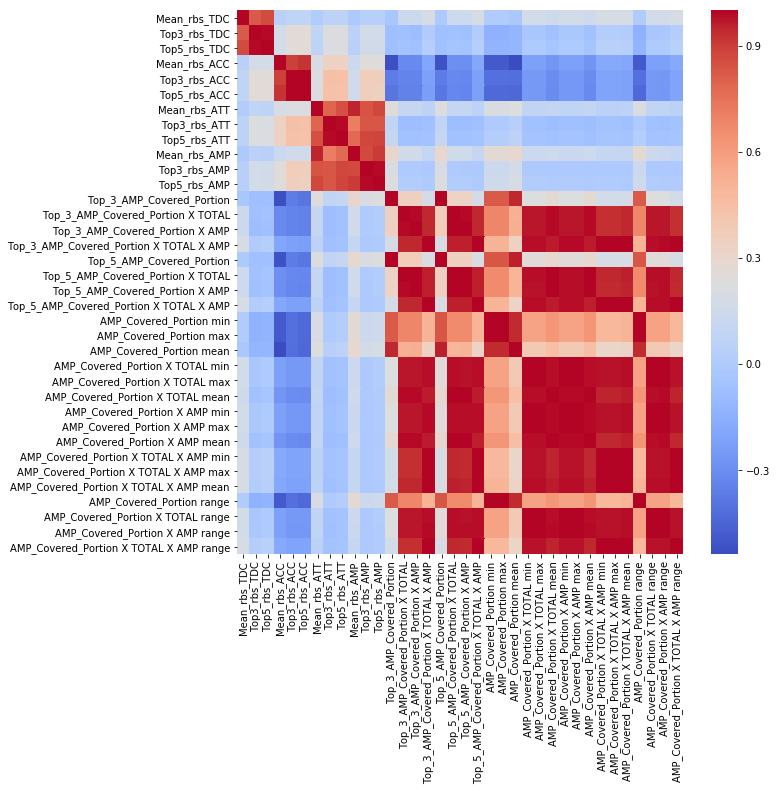

In [35]:
plt.figure(figsize=(10,10))
sns.heatmap(final_df_rbs.corr(), cmap="coolwarm")

#### As you can see, heatmap is not clear because of the order of columns. To make it simple and clear, I will rearrange the order

In [36]:
# Check column names
final_df_rbs.columns

Index(['Mean_rbs_TDC', 'Top3_rbs_TDC', 'Top5_rbs_TDC', 'Mean_rbs_ACC',
       'Top3_rbs_ACC', 'Top5_rbs_ACC', 'Mean_rbs_ATT', 'Top3_rbs_ATT',
       'Top5_rbs_ATT', 'Mean_rbs_AMP', 'Top3_rbs_AMP', 'Top5_rbs_AMP',
       'Top_3_AMP_Covered_Portion', 'Top_3_AMP_Covered_Portion X TOTAL',
       'Top_3_AMP_Covered_Portion X AMP',
       'Top_3_AMP_Covered_Portion X TOTAL X AMP', 'Top_5_AMP_Covered_Portion',
       'Top_5_AMP_Covered_Portion X TOTAL', 'Top_5_AMP_Covered_Portion X AMP',
       'Top_5_AMP_Covered_Portion X TOTAL X AMP', 'AMP_Covered_Portion min',
       'AMP_Covered_Portion max', 'AMP_Covered_Portion mean',
       'AMP_Covered_Portion X TOTAL min', 'AMP_Covered_Portion X TOTAL max',
       'AMP_Covered_Portion X TOTAL mean', 'AMP_Covered_Portion X AMP min',
       'AMP_Covered_Portion X AMP max', 'AMP_Covered_Portion X AMP mean',
       'AMP_Covered_Portion X TOTAL X AMP min',
       'AMP_Covered_Portion X TOTAL X AMP max',
       'AMP_Covered_Portion X TOTAL X AMP mean', 'AM

In [37]:
# Reorder column names
final_df_rbs = final_df_rbs[['Mean_rbs_ACC', 'Top3_rbs_ACC', 'Top5_rbs_ACC',
            'Mean_rbs_ATT','Top3_rbs_ATT', 'Top5_rbs_ATT', 'Mean_rbs_AMP', 'Top3_rbs_AMP','Top5_rbs_AMP',
            'Top_3_AMP_Covered_Portion','Top_5_AMP_Covered_Portion','AMP_Covered_Portion mean', 'AMP_Covered_Portion range','AMP_Covered_Portion min',
       'AMP_Covered_Portion max', 
       'Top_3_AMP_Covered_Portion X TOTAL', 'Top_3_AMP_Covered_Portion X AMP',
       'Top_3_AMP_Covered_Portion X TOTAL X AMP', 
       'Top_5_AMP_Covered_Portion X TOTAL', 'Top_5_AMP_Covered_Portion X AMP',
       'Top_5_AMP_Covered_Portion X TOTAL X AMP', 
       'AMP_Covered_Portion X TOTAL min', 'AMP_Covered_Portion X TOTAL max',
       'AMP_Covered_Portion X TOTAL mean', 'AMP_Covered_Portion X AMP min',
       'AMP_Covered_Portion X AMP max', 'AMP_Covered_Portion X AMP mean',
       'AMP_Covered_Portion X TOTAL X AMP min',
       'AMP_Covered_Portion X TOTAL X AMP max',
       'AMP_Covered_Portion X TOTAL X AMP mean', 
       'AMP_Covered_Portion X TOTAL range', 'AMP_Covered_Portion X AMP range',
       'AMP_Covered_Portion X TOTAL X AMP range']]

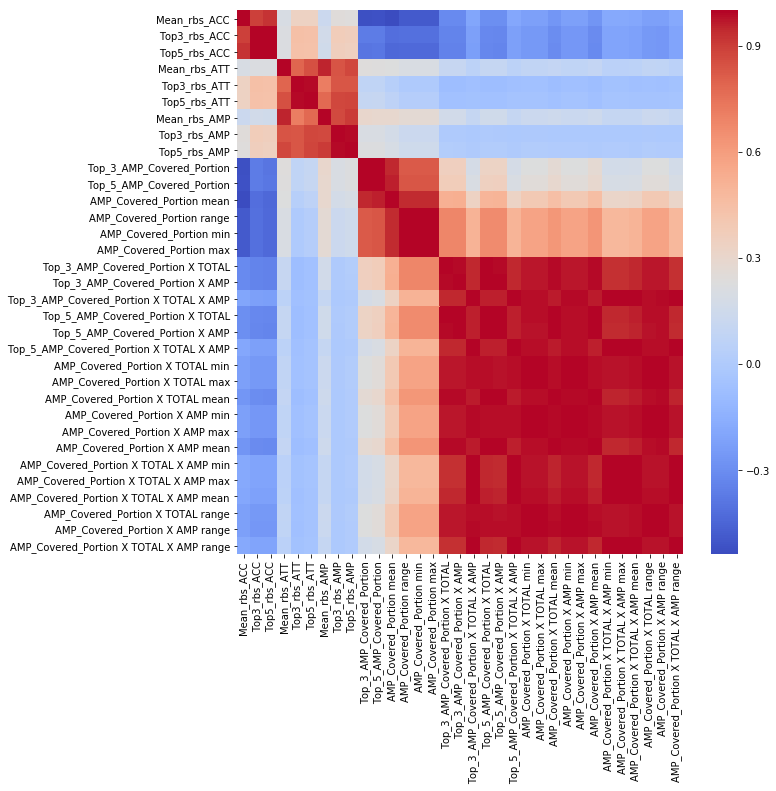

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(final_df_rbs.corr(), cmap="coolwarm")

#### Now, we can see more intuiutve heatmap. We define four sections with high correlations. 

### PCA for dimension reduction

#### Because we found high correlcation, I will conduct PCA to make 4 principal component according to correlation.

In [39]:
# PCA 
pca  = PCA(n_components=4)
pca_fit = pca.fit(final_df_rbs)
pd.DataFrame(pca_fit.components_, columns=final_df_rbs.columns)

,Mean_rbs_ACC,Top3_rbs_ACC,Top5_rbs_ACC,Mean_rbs_ATT,Top3_rbs_ATT,Top5_rbs_ATT,Mean_rbs_AMP,Top3_rbs_AMP,Top5_rbs_AMP,Top_3_AMP_Covered_Portion,Top_5_AMP_Covered_Portion,AMP_Covered_Portion mean,AMP_Covered_Portion range,AMP_Covered_Portion min,AMP_Covered_Portion max,Top_3_AMP_Covered_Portion X TOTAL,Top_3_AMP_Covered_Portion X AMP,Top_3_AMP_Covered_Portion X TOTAL X AMP,Top_5_AMP_Covered_Portion X TOTAL,Top_5_AMP_Covered_Portion X AMP,Top_5_AMP_Covered_Portion X TOTAL X AMP,AMP_Covered_Portion X TOTAL min,AMP_Covered_Portion X TOTAL max,AMP_Covered_Portion X TOTAL mean,AMP_Covered_Portion X AMP min,AMP_Covered_Portion X AMP max,AMP_Covered_Portion X AMP mean,AMP_Covered_Portion X TOTAL X AMP min,AMP_Covered_Portion X TOTAL X AMP max,AMP_Covered_Portion X TOTAL X AMP mean,AMP_Covered_Portion X TOTAL range,AMP_Covered_Portion X AMP range,AMP_Covered_Portion X TOTAL X AMP range
0,-0.078615,-0.080446,-0.082112,0.024781,-0.016171,-0.011603,0.037953,0.002822,0.006751,0.090379,0.095148,0.126221,0.160771,0.160771,0.160771,0.222713,0.223025,0.216608,0.223605,0.223410,0.216236,0.220497,0.220497,0.222120,0.220804,0.220804,0.221849,0.213834,0.213834,0.215938,0.220497,0.220804,0.213834
1,0.121982,0.170870,0.165952,0.372458,0.365159,0.380675,0.366346,0.386833,0.392280,0.127738,0.127704,0.112653,0.088383,0.088383,0.088383,-0.004386,-0.004796,-0.022997,-0.006871,-0.007218,-0.022994,-0.013775,-0.013775,-0.013520,-0.015922,-0.015922,-0.013830,-0.022223,-0.022223,-0.023145,-0.013775,-0.015922,-0.022223
2,-0.317920,-0.274596,-0.283403,-0.017028,-0.089002,-0.082454,0.007448,-0.036046,-0.032110,0.358269,0.354120,0.337439,0.271334,0.271334,0.271334,-0.016943,-0.015912,-0.112638,-0.031340,-0.029397,-0.114741,-0.086029,-0.086029,-0.054571,-0.086301,-0.086301,-0.052113,-0.122755,-0.122755,-0.116771,-0.086029,-0.086301,-0.122755
3,0.404742,0.487185,0.482241,-0.210354,-0.105260,-0.115460,-0.215187,-0.118892,-0.128859,0.183548,0.193208,0.189971,0.192958,0.192958,0.192958,0.002238,0.002078,-0.016416,0.002243,0.002123,-0.015627,-0.005299,-0.005299,-0.010886,-0.007206,-0.007206,-0.010723,-0.013141,-0.013141,-0.015572,-0.005299,-0.007206,-0.013141


In [40]:
# Get PCA values
principalComponents = pca.fit_transform(final_df_rbs)

#### Now, we have four features, but column names are just number. By checking their eigenvectors, I will assign new proper names.

#### AMP: Relative values of Average Medicare Payment. 
#### ACC&ATT: Relative values of Average Covered Charges and Averge Total Payments.
#### AMP_Portion : Relative values of the portion of Averge Medicare Payments out of Average Covered Charges
#### AMP_Portion_DRG_Concentration: Similar to 'AMP_Portion', but it includes the amount and frequency

In [41]:
# Rename for columns
pca_df = pd.DataFrame(principalComponents, columns=['AMP_Portion_DRG_Concentration','AMP','AMP_Portion','ACC&ATT'])

In [42]:
# Final dataset
pca_df.head()

,AMP_Portion_DRG_Concentration,AMP,AMP_Portion,ACC&ATT
0,-1.513989,-0.285319,-1.008963,-0.444801
1,-0.521805,0.282126,1.368544,-0.864177
2,-1.640645,-0.752270,-1.179507,-0.464314
3,-1.192087,0.136350,-0.131384,-0.528657
4,-1.813178,0.009311,-1.914617,0.175024


# Kmeans

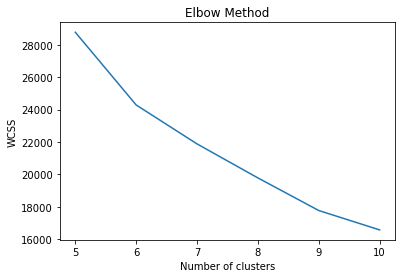

In [43]:
# K meanse Clustering
wcss = []

for i in range(5, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(5, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [44]:
# Fit with 10 clusters
estimator = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=10, random_state=0)
estimator.fit(pca_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [45]:
# Check the characteristics of the 10 clusters
knn_result = pd.DataFrame(estimator.cluster_centers_, columns=pca_df.columns)
knn_result['size'] = pd.Series(estimator.labels_).value_counts()
knn_result

,AMP_Portion_DRG_Concentration,AMP,AMP_Portion,ACC&ATT,size
0,-1.613171,-0.608021,-1.527250,0.297648,787
1,31.377221,-0.945012,-4.148516,-0.067714,25
2,-0.762573,-1.440303,0.215361,-0.339350,1086
3,0.649625,-0.421785,2.406327,-0.070193,580
4,11.386880,-2.316047,-2.835891,-0.571035,66
5,-2.111919,1.907167,-3.384113,1.528634,198
6,-0.448894,9.353822,-1.096681,-1.293892,83
7,-0.768791,2.530779,-0.250277,-0.676217,356
8,50.033587,2.223899,-4.556774,1.487613,9
9,3.154954,2.645188,5.132406,1.676511,147


In [47]:
# Add cluster label
knn_df = pd.concat([pca_df, pd.Series(estimator.labels_)], axis=1, sort=False)
knn_df = knn_df.rename(columns={'0':'Cluster'})

In [51]:
knn_df = knn_df.rename(columns={0: 'Cluster'})
knn_df.head()

,AMP_Portion_DRG_Concentration,AMP,AMP_Portion,ACC&ATT,Cluster
0,-1.513989,-0.285319,-1.008963,-0.444801,0
1,-0.521805,0.282126,1.368544,-0.864177,3
2,-1.640645,-0.752270,-1.179507,-0.464314,0
3,-1.192087,0.136350,-0.131384,-0.528657,2
4,-1.813178,0.009311,-1.914617,0.175024,0


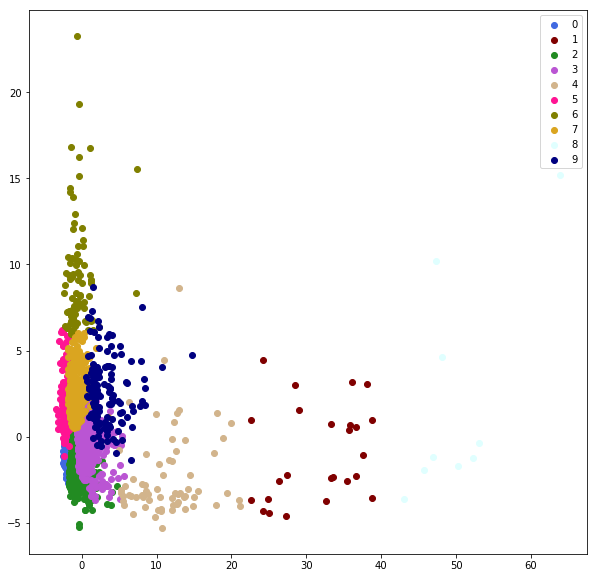

In [54]:
# Plot with 2 main components
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']

fig, ax = plt.subplots(figsize=(10,10))
for g in np.unique(knn_df['Cluster']):
    ix = np.where(knn_df['Cluster'] == g)
    ax.scatter(knn_df.iloc[ix]['AMP_Portion_DRG_Concentration'], knn_df.iloc[ix]['AMP'], c = colors[g])
ax.legend(np.unique(knn_df['Cluster']))

# DBScan

In [55]:
# Set new data name for DBScan
DBS_df = pca_df

In [56]:
# Check KNN distance for DBScan parameters
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(DBS_df)
distances, indices = nbrs.kneighbors(DBS_df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

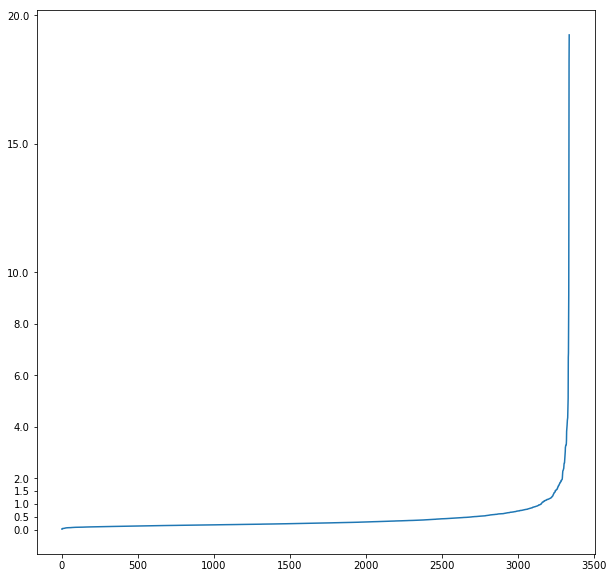

In [57]:
# KNN distance plot
plt.figure(figsize=(10,10))
plt.yticks([0,0.5,1,1.5,2,4,6,8,10, 15, 20])
plt.plot(distances)

### Finding: According to the plot, 1.5 would be a good  eps here.

In [58]:
# DBScan (EPS=1.5, min_sample=5)
db = DBSCAN(eps=1.5, min_samples=5).fit(DBS_df) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ 

In [59]:
# Check the number of clusters
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

In [60]:
# Add cluster label
DBS_df['cluster'] = pd.Series(labels)

### Check the chracteristic of each cluster 

In [61]:
# Groupby with cluster
DBS_df.groupby('cluster').aggregate({'AMP_Portion_DRG_Concentration':['mean'],
                                     'AMP':['mean'],
                                     'AMP_Portion':['mean'],
                                     'ACC&ATT':['mean'],
                                     'cluster': ['count']})

,AMP_Portion_DRG_Concentration,AMP,AMP_Portion,ACC&ATT,cluster
,mean,mean,mean,mean,count
cluster,,,,,
-1,10.846688,3.577540,-0.499808,0.460677,166
0,-0.732730,-0.200179,0.048053,-0.008813,3099
1,-0.883269,9.750246,-1.242607,-1.733384,12
2,1.336227,6.296393,3.414972,-1.443953,5
3,3.889644,3.149962,6.323624,0.652736,11
4,13.473022,-3.512770,-3.296181,-0.492943,16
5,7.705170,-3.587368,-3.033359,-0.729759,28


### Plot for DBScan

In [62]:
# Set the color
colors = ['navy', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'royalblue', 'olive', 'deeppink']

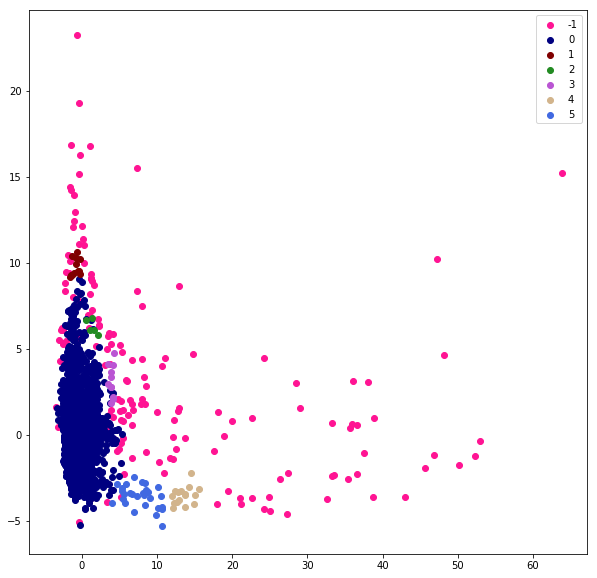

In [63]:
# Scatter Plot
fig, ax = plt.subplots(figsize=(10,10))
for g in np.unique(DBS_df['cluster']):
    ix = np.where(DBS_df['cluster'] == g)
    ax.scatter(DBS_df.iloc[ix]['AMP_Portion_DRG_Concentration'], DBS_df.iloc[ix]['AMP'], c = colors[g])
ax.legend(np.unique(DBS_df['cluster']))

###  The result is not good enough than I expected, so I will change parameters to check it more

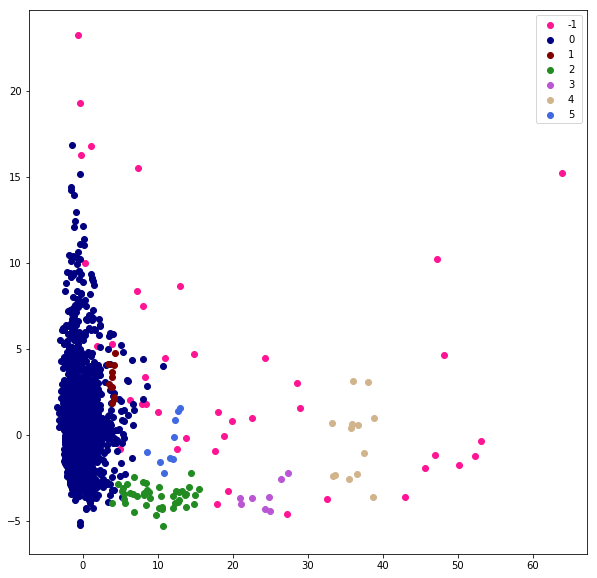

In [64]:
# DBScan (EPS=3.0, min_sample=5)
db = DBSCAN(eps=3.0, min_samples=5).fit(DBS_df) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ 

DBS_df['cluster'] = pd.Series(labels)

colors = ['navy', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'royalblue', 'olive', 'deeppink']

fig, ax = plt.subplots(figsize=(10,10))
for g in np.unique(DBS_df['cluster']):
    ix = np.where(DBS_df['cluster'] == g)
    ax.scatter(DBS_df.iloc[ix]['AMP_Portion_DRG_Concentration'], DBS_df.iloc[ix]['AMP'], c = colors[g])
ax.legend(np.unique(DBS_df['cluster']))

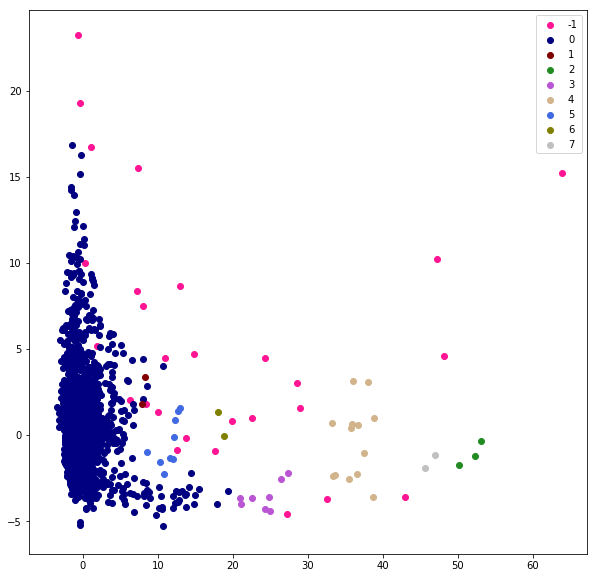

In [67]:
# DBScan (EPS=1.5, min_sample=2)
db = DBSCAN(eps=3.0, min_samples=2).fit(DBS_df) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ 

DBS_df['cluster'] = pd.Series(labels)

colors = ['navy', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'royalblue', 'olive', 'silver','deeppink']

fig, ax = plt.subplots(figsize=(10,10))
for g in np.unique(DBS_df['cluster']):
    ix = np.where(DBS_df['cluster'] == g)
    ax.scatter(DBS_df.iloc[ix]['AMP_Portion_DRG_Concentration'], DBS_df.iloc[ix]['AMP'], c = colors[g])
ax.legend(np.unique(DBS_df['cluster']))

### Finding: As you can see, results are not good regardelss of parameters. It can find many outliers. Also, it can't tell two types of outlier clusters.

# MeanShift

In [68]:
# Set new data name
MS_df = pca_df.drop('cluster', axis=1)

In [69]:
# Test the result with several parameters(1~15)
for i in range(1,16):
    ms = MeanShift(bandwidth = i,
               seeds=None, 
               bin_seeding=False, 
               min_bin_freq=1, 
               cluster_all=True, 
               n_jobs=None)
    clustering = ms.fit(MS_df)
    n_cluster = np.unique(clustering.labels_)
    print("Bandwidth {}: {}".format(i, n_cluster))
    

Bandwidth 1: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 2

In [70]:
# According to the test, I will use 7 for bandwith because it has proper number of parameter.
ms = MeanShift(bandwidth = 7,
               seeds=None, 
               bin_seeding=False, 
               min_bin_freq=1, 
               cluster_all=True, 
               n_jobs=None)
clustering = ms.fit(MS_df)
labels = clustering.labels_
MS_df['cluster'] = pd.Series(labels)

In [71]:
# Groupby with clusters
MS_df.groupby('cluster').aggregate({'AMP_Portion_DRG_Concentration':['mean'],
                                     'AMP':['mean'],
                                     'AMP_Portion':['mean'],
                                     'ACC&ATT':['mean'],
                                     'cluster': ['count']})

,AMP_Portion_DRG_Concentration,AMP,AMP_Portion,ACC&ATT,cluster
,mean,mean,mean,mean,count
cluster,,,,,
0,-0.446364,-0.078208,0.043609,0.005378,3272
1,31.497066,-1.110459,-4.569464,-0.252748,24
2,48.456818,-0.768419,-5.932656,1.427142,7
3,63.831120,15.193063,-8.645716,-3.530597,1
4,47.273442,10.200958,9.163343,6.929118,1
5,19.608074,-1.090672,-0.915994,0.584866,10
6,3.020309,11.789297,1.318846,-2.105405,20
7,-1.107112,18.826064,-4.613536,5.669412,2


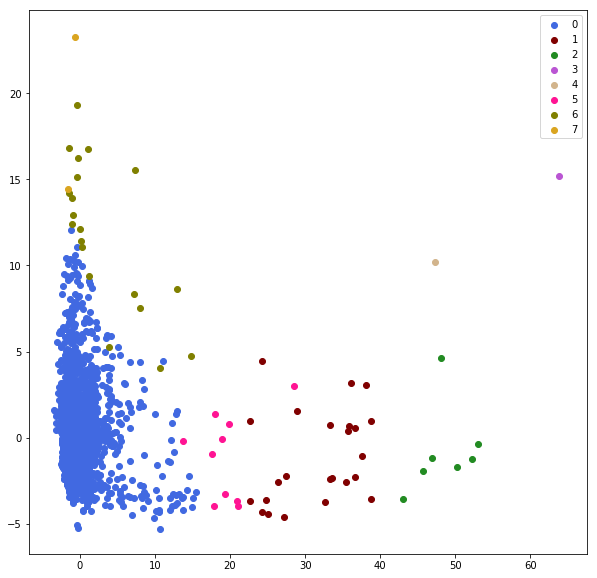

In [72]:
# Plot for MeanShift
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']

fig, ax = plt.subplots(figsize=(10,10))
for g in np.unique(MS_df['cluster']):
    ix = np.where(MS_df['cluster'] == g)
    ax.scatter(MS_df.iloc[ix]['AMP_Portion_DRG_Concentration'], MS_df.iloc[ix]['AMP'], c = colors[g])
ax.legend(np.unique(MS_df['cluster']))

### Finding: It looks a much better result because only outliers belongs to a certain cluster, while most normal object belong to one cluster(blue). To be specific, the cluster 6 and 7 shows high AMP values, so it could be related to assumption 1, but some of cluster 6 should be removed. Also, the cluster 2,3, and 4 might be suspicious cases related to assumption 2 with a high value of AMP_Portion_DRG_Concentration.  